In [1]:
import pickle
import networkx as nx
import pickle
import numpy as np
import pandas as pd
import community
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
with open('df_final.pickle', 'rb') as f:
    df_final = pickle.load(f)
with open('G.pickle', 'rb') as f:
    G = pickle.load(f)

In [3]:
def computeModularity(G, partition):
    #Here the partition input is an attribute that we will partition the data set by
    partitions = np.unique(list(nx.get_node_attributes(G,partition).values()))
    partition_dic = {part: [] for part in partitions}
    
    N = len(G.nodes())
    L = len(G.edges())
    
    modularity = 0
    #sort nodes into their respective communities
    for key in partition_dic.keys():
        for node in G.nodes():
            part = G.nodes[node][partition]
            partition_dic[part].append(node)
        community = nx.Graph.subgraph(G, partition_dic[key])
        k_c = sum([G.degree(v) for v in community])
        L_c = len(community.edges())

        #compuute modularity
        modularity += (L_c / L) - (k_c/(2*L))**2
        
    return modularity
print("Modularity score for affiliation partition:", round(computeModularity(G,'Affiliation'),4))

Modularity score for affiliation partition: 0.0705


In [31]:
partition = community.best_partition(G)
# add the Louvain community as attributes for the nodes:
for node in G.nodes():
    G.nodes()[node]['louvain'] = partition[node]

In [33]:
# saving partition
with open('louvain.pickle', 'wb') as handle:
    pickle.dump(partition, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
np.unique(list(partition.values()))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [34]:
# we count the number of communities:
print("Number of communities:", len(np.unique(list(partition.values()))))

# And count number of nodes in each community:
partitions = np.unique(list(partition.values()))
partition_dic = {parti: [] for parti in partitions}
for parti in partition_dic.keys():
    count = 0
    for key in partition:
        if partition[key] == parti:
            count += 1
    partition_dic[parti]=count
print("Community sizes:",partition_dic)

Number of communities: 14
Community sizes: {0: 161, 1: 130, 2: 212, 3: 235, 4: 221, 5: 125, 6: 137, 7: 10, 8: 6, 9: 140, 10: 212, 11: 195, 12: 128, 13: 49}


In [35]:
print("Modularity score for louvain partition:", round(computeModularity(G,'louvain'),4))

Modularity score for louvain partition: 0.4891


In [36]:
#find top 10 largest communities
top_10 = [x[0] for x in sorted(partition_dic.items(), key=lambda x: x[1], reverse=True)][:10]
print("Top 10 largest communities:", top_10)

Top 10 largest communities: [3, 4, 2, 10, 11, 0, 9, 6, 1, 12]


In [37]:
from nltk.corpus import stopwords
from tqdm import tqdm
community_dic = {part: [] for part in partition_dic.keys()}
for part in tqdm(partition_dic.keys()):#for each community 
    community_doc = str()
    for node in [key for (key,value) in partition.items() if value==part]:#for each character in that community
        tokens = list(df_final.loc[df_final["Name"]==node]['Clean Text'])#Extract clean text from data frame
        
        
        if len(tokens)!=0:#handle nodes with no text
            community_doc +=' '+ tokens[0]#add extra space to ensure we can split into tokens later
        else:
            break
    #tokenize:
    community_dic[part]=community_doc

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:01<00:00, 13.56it/s]


In [38]:
#calculate TF

from nltk.tokenize import word_tokenize
alphabet = 'abcdefghijklmnopqrstuvwxyz'

token_dic = {}
for part in tqdm(community_dic.keys()):#for each community
    tokens = word_tokenize(community_dic[part])#divide text into tokens
    text = community_dic[part]
    token_list = []
    for token in tokens:
        if len(token) != 0:
            token = token.lower()
            
            if token[0] in alphabet and token[-1] in alphabet:#remove punctuation and signs
                token_list.append(token)
    token_dic[part]=token_list

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:43<00:00,  3.08s/it]


In [39]:
TF_outer_dic =  {} 
for part in tqdm(top_10):
    TF_dic = {}
    for token in token_dic[part]:
        if token not in TF_dic.keys():
            TF_dic[token]=token_dic[part].count(token)#count frequency
    TF_outer_dic[part]=TF_dic

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:50<00:00, 23.05s/it]


In [40]:
N = 10
IDF_outer_dic = {}
for part in top_10:#for each community
    IDF_dic = {}
    for word in tqdm(TF_outer_dic[part].keys()):#for each word in that community
        
        count = 0
        for part2 in top_10:
            if word in token_dic[part2]:
                count += 1 #count occurences in all documents
        IDF_dic[word]=np.log(N/count)#uses natural log
    IDF_outer_dic[part]=IDF_dic

100%|█████████████████████████████████████████████████████████████████████████████| 8359/8359 [01:20<00:00, 103.41it/s]


In [42]:
TF_IDF_outer_dic = {}
for part in tqdm(top_10):
    TF_IDF_dic = {}
    for word in IDF_outer_dic[part].keys():
        TF_IDF_dic[word]=TF_outer_dic[part][word]*IDF_outer_dic[part][word]
    TF_IDF_outer_dic[part]=TF_IDF_dic
massive_dic = {'TF':TF_outer_dic,'IDF':IDF_outer_dic,'TF_IDF':TF_IDF_outer_dic}

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 144.74it/s]


In [43]:
TF_IDF_outer_dic

{3: {"mal'ganis": 61.29907485191889,
  'or': 0.0,
  'was': 0.0,
  'one': 0.0,
  'of': 0.0,
  'the': 0.0,
  'nathrezim': 23.653216439306235,
  'sent': 0.0,
  'by': 0.0,
  'archimonde': 4.741223204602186,
  'as': 0.0,
  'a': 0.0,
  'jailor': 0.6694306539426294,
  'lich': 0.0,
  'king': 0.0,
  'he': 0.0,
  'chosen': 0.0,
  'to': 0.0,
  'head': 0.0,
  'up': 0.0,
  'plot': 0.0,
  'turn': 0.0,
  'prince': 0.0,
  'arthas': 93.5601379041498,
  'menethil': 0.0,
  'darkness': 0.0,
  'and': 0.0,
  'make': 0.0,
  'him': 0.0,
  'greatest': 0.0,
  'champion': 0.0,
  'before': 0.0,
  'being': 0.0,
  'betrayed': 0.0,
  'killed': 0.0,
  'death': 0.0,
  'knight': 22.23106880380136,
  'during': 0.0,
  'war': 0.0,
  'against': 0.0,
  'led': 0.0,
  'scarlet': 62.70333791929294,
  'onslaught': 0.0,
  'under': 0.0,
  'guise': 1.3696867035517426,
  'barean': 11.51292546497023,
  'westwind': 7.330325854993241,
  'plotting': 2.4967246075711267,
  'take': 0.0,
  'revenge': 0.0,
  'overthrow': 0.44628710262841953

In [44]:
# adapted from: https://stackoverflow.com/a/43043723

def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * float(np.random.randint(0, 255)) / 255.0)
    s = int(100.0 * float(np.random.randint(0, 255)) / 255.0)
    l = int(100.0 * float(np.random.randint(0, 255)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

random_color_func()

'hsl(249, 63%, 88%)'

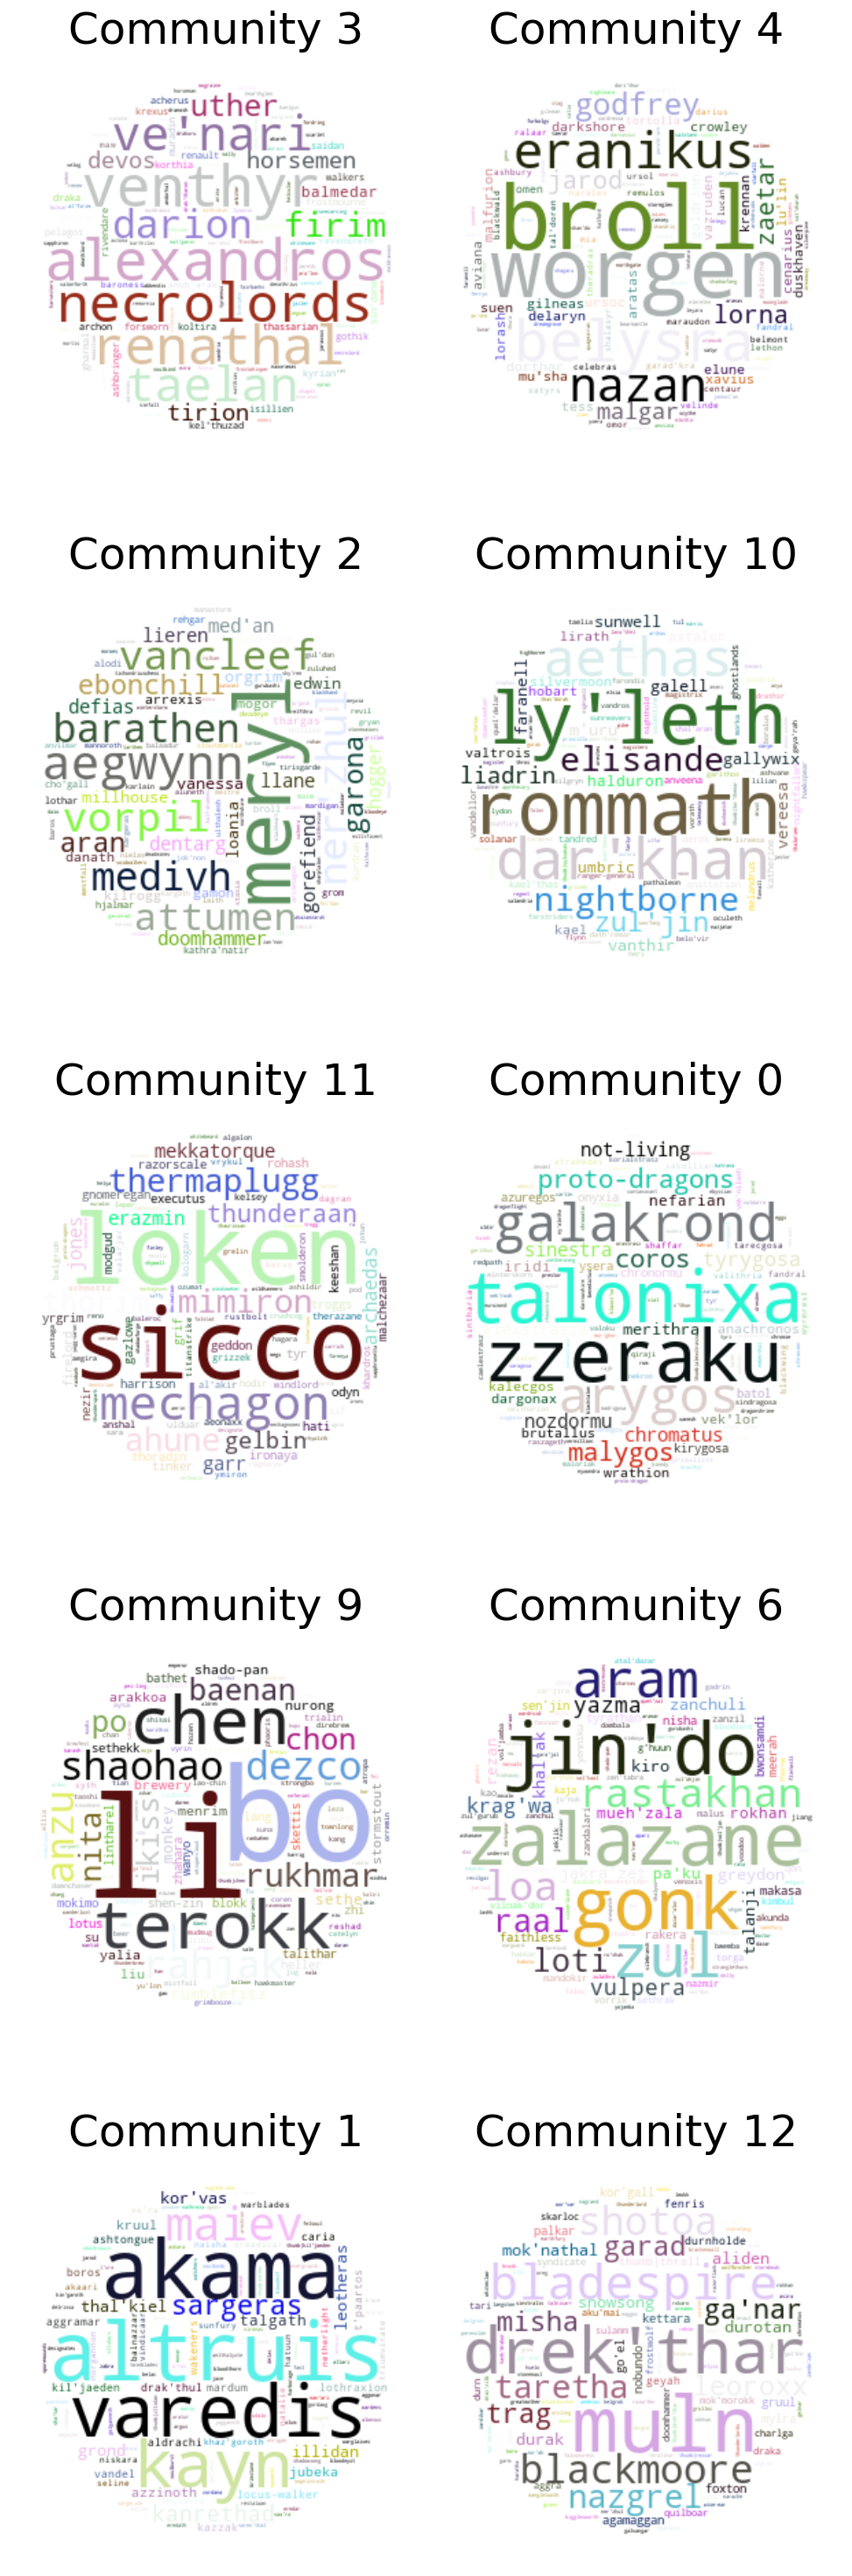

In [63]:
# taken from: https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py

tf_idf = TF_IDF_outer_dic

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

fig = plt.figure(figsize=(8,25),dpi=120,constrained_layout=True)
i=1

for key in tf_idf.keys():
    TF_IDF = tf_idf[key]
    
    wc = WordCloud(background_color="white", repeat=True, mask=mask, color_func=random_color_func)
    # make wordcloud from TF-IDF
    wordcloud = wc.generate_from_frequencies(TF_IDF)
    
    ax = fig.add_subplot(5,2,i)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title("Community {}".format(key), size=30)
    ax.axis("off")
    i+=1

plt.savefig("wordclouds.png", dpi=400);
    
plt.show()

Community 3: Shadowlands? Alexandros is the leader of the four horsemen. Also Tirion, Taelan, and more are paladins
Community 4: Night elves
Community 0: Dragons and proto-dragons
Community 9: Pandarens, hozens (monke), brewmaster
Community 6: Trolls, zalazane, rastakhan, and jin'do are trolls, gonk is a loa (god worshipped by trolls)

In [17]:
# saving the df's
with open('massive_dic.pickle', 'wb') as handle:
    pickle.dump(massive_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)